**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for personal scientific use. The crib sheet (or elements of the crib sheet) must not be ingested into third party libraries without written consent of the UCalgary team. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Georeferencing Single-Channel ASI Data**
---

### **Datasets**
All datasets can be found at https://data.phys.ucalgary.ca/. This crib sheet currently pertains to the following datasets:
- THEMIS ASI
- REGO
- TREx NIR
- *TREx Blueline - Skymaps Coming Soon*

</br>

### **Crib Sheet Summary**
With the code in this crib sheet, one can create mosaics from single-channel images in data numbers, scaled data numbers, or calibrated luminosity (i.e., Rayleighs).

Multi-channel imager mosaics and mosaics with multiple network (camera) types are covered in other crib sheets.

Note: this crib sheet utilizes geospatial calbration of ASIs, information on the UCalgary geospatial calibration files can be found here, https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf

</br>

---

</br>


## **Setup**

Install required dependencies using pip

In [2]:
!pip install themis-imager-readfile rego-imager-readfile trex-imager-readfile nascam-imager-readfile aacgmv2 cartopy pyproj matplotlib scipy requests joblib tqdm

In [5]:
# Before doing anything, one must install the readfile associated with the dataset they are interested in. In this case, we import the
# THEMIS, REGO, TREx, and NASCAM readfiles for completeness, although one may opt to install only what is necessary.
#
# We will also require some additional packages, so they are imported as well.

import os
import pprint
import glob
import getpass
import datetime as dt
import themis_imager_readfile
import rego_imager_readfile
import trex_imager_readfile
import nascam_imager_readfile
import aacgmv2
import cv2
import cartopy
import pyproj
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import requests
import joblib
from tqdm.notebook import tqdm

## **Downloading Data**

We need to download the data we're going to be using. UCalgary provides an API to help with this, and will be working further to make this process easier. You can learn more about how to use the API to download data by checking out the crib sheet for it on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible.

In [6]:
# set the top-level output path we want to save the files to
#
# NOTE: This crib sheet assumes you're using a Windows computer. Change as needed.
download_root_path = os.path.join("C:", os.sep, "Users", getpass.getuser(), "Desktop", "ucalgary_data")

In [7]:
# These functions are helpers for downloading data, we won't go into any detail
# here, but just use them later on. Learn more by checking out the 'Downloading data
# from the API' crib sheet on data.phys.ucalgary.ca.

def download_url(url, prefix, output_base_path, overwrite=False, pbar=None):
    # set output filename
    output_filename = "%s/%s" % (output_base_path, url.removeprefix(prefix))
    if (overwrite is False and os.path.exists(output_filename)):
        if (pbar is not None):
            pbar.update()
        return

    # create destination directory
    try:
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    except Exception:
        # NOTE: sometimes when making directories in parallel there are race conditions. We put
        # in a catch here and carry on if there are ever issues.
        pass

    # retrieve file and save to disk
    r = requests.get(url)
    with open(output_filename, 'wb') as fp:
        fp.write(r.content)

    # advance progress bar
    if (pbar is not None):
        pbar.update()

def download_urls(dataset, urls, output_base_path, n_parallel=5, overwrite=False):
    prefix_to_strip = dataset["data_tree_url"]
    with tqdm(total=len(urls), desc="Downloading and saving files to disk") as pbar:
        joblib.Parallel(n_jobs=n_parallel, prefer="threads")(
            joblib.delayed(download_url)(
                urls[i],
                prefix_to_strip,
                os.path.join(output_base_path, dataset["name"]),
                overwrite=overwrite,
                pbar=pbar,
            ) for i in range(0, len(urls))
        )

def get_data_urls(dataset_name, start, end, site_uid=None):
    if (site_uid is None):
        params = {"name": dataset_name, "start": start, "end": end, "include_total_bytes": True}
    else:
        params = {"name": dataset_name, "start": start, "end": end, "site_uid": site_uid, "include_total_bytes": True}
    r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/urls", params=params)
    data = r.json()
    return data

def list_datasets(name=None):
    if (name is not None):
        params = {"name": name}
        r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/datasets", params=params)
    else:
        r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/datasets")
    datasets = r.json()
    return datasets

In [8]:
# download an hour of REGO data from Gillam
dataset_name = "REGO_STREAM0_RAW"
start = "2023-02-24T06:00"
end = "2023-02-24T06:59"
site_uid = "gill"
dataset = list_datasets(name=dataset_name)[0]
urls = get_data_urls(dataset_name, start, end, site_uid)["urls"]
download_urls(dataset, urls, download_root_path)

# download 1 minute of REGO data from all sites
dataset_name = "REGO_STREAM0_RAW"
start = "2023-02-24T06:40"
end = "2023-02-24T06:40"
urls = get_data_urls(dataset_name, start, end)["urls"]
download_urls(dataset, urls, download_root_path)

# download another 1 minute of REGO data from all sites
dataset_name = "REGO_STREAM0_RAW"
start = "2023-02-24T06:15"
end = "2023-02-24T06:15"
urls = get_data_urls(dataset_name, start, end)["urls"]
download_urls(dataset, urls, download_root_path)

# download REGO skymaps
urls = [
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap/fsim/fsim_20220902/rego_skymap_fsim_20220902-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap/gill/gill_20230124/rego_skymap_gill_20230124-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap/luck/luck_20220902/rego_skymap_luck_20220902-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap/rank/rank_20221214/rego_skymap_rank_20221214-+_v01.sav',
]
prefix = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/skymap"  # this is used for saving the files to the place we want
for url in tqdm(urls, desc="Downloading and saving files to disk"):
  download_url(url, prefix, os.path.join(download_root_path, "skymap", "rego"), pbar=None)

# download REGO calibration files
urls = [
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_flatfield_15656_20220613-+_v02.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_flatfield_15652_20141102-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_flatfield_15651_20210908-+_v02.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_flatfield_15649_20211019-+_v02.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_Rayleighs_15656_20220613-+_v02.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_Rayleighs_15652_20141102-+_v01.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_Rayleighs_15651_20210908-+_v02.sav',
    'https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO/calibration/REGO_Rayleighs_15649_20211019-+_v02.sav',
]
prefix = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/REGO"  # this is used for saving the files to the place we want
for url in tqdm(urls, desc="Downloading and saving files to disk"):
  download_url(url, prefix, download_root_path, pbar=None)

# download 1 minute of THEMIS ASI data from all sites
dataset_name = "THEMIS_ASI_STREAM0_RAW"
start = "2023-02-24T06:40"
end = "2023-02-24T06:40"
dataset = list_datasets(name=dataset_name)[0]
for site_uid in ['fsmi', 'gill', 'inuv', 'atha', 'talo']:
    urls = get_data_urls(dataset_name, start, end, site_uid)["urls"]
    download_urls(dataset, urls, download_root_path)

# download THEMIS skymaps
urls = [
    "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/talo/talo_20230214/themis_skymap_talo_20230214-+_v02.sav",
    "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/inuv/inuv_20230312/themis_skymap_inuv_20230312-+_v02.sav",
    "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/gill/gill_20230220/themis_skymap_gill_20230220-+_v02.sav",
    "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/fsmi/fsmi_20230321/themis_skymap_fsmi_20230321-+_v02.sav",
    "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps/atha/atha_20230115/themis_skymap_atha_20230115-+_v02.sav",
]
prefix = "https://data.phys.ucalgary.ca/sort_by_project/THEMIS/asi/skymaps"  # this is used for saving the files to the place we want
for url in tqdm(urls, desc="Downloading and saving files to disk"):
  download_url(url, prefix, os.path.join(download_root_path, "skymap", "themis"), pbar=None)

## **Georeferencing Keograms**

Creating keograms is covered in the 'Loading, Calibrating, and Plotting Single Channel ASI Data' crib sheet, but it is often useful to be able to georeference a koegram's axes.

In [9]:
# Grab 1-hour of data to generate a keogram
# See 'Loading, Calibrating, and Plotting Single Channel ASI Data' cribsheet as required.

filename_list = sorted(glob.glob(os.path.join(download_root_path, 'REGO_STREAM0_RAW', '2023', '02', '24', 'gill_rego-652', 'ut06', '20230224_06*_gill_rego-652_6300.pgm.gz')))

# Read in the data and orient correctly
img_flipped, meta, problematic_files = rego_imager_readfile.read(filename_list, workers=os.cpu_count())
img = np.flip(img_flipped, axis=1)



---


For each camera, the UCalgary maintains a geospatial calibration dataset that maps pixel coordinates (detector X and Y) to local observer and geodetic coordinates (at altitudes of interest). We refer to this calibration as a 'skymap'. The skymaps may change due to the freeze-thaw cycle and changes in the building, or when the instrument is serviced. A skymap is valid from the date it is produced, until it is superseded by another file.

Be sure you choose the correct skymap for your data timeframe. You can view all skymaps by looking at the data tree for the imager you are using (see https://data.phys.ucalgary.ca/). If you believe the geospatial calibration may be incorrect, please contact the UCalgary team.

For more on the skymap files, please see https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf



---



In [10]:
# Get the skymap corresponding to this image data
skymap_file = os.path.join(download_root_path, 'skymap', 'rego', 'gill', 'gill_20230124', 'rego_skymap_gill_20230124-+_v01.sav')

In [11]:
# This function can be used to read a skymap (IDL .sav file) into
# a Python dictionary for use.
def restore_skymap(skymap_f_path):

    # First returns a numpy record array
    skymap_obj = scipy.io.readsav(skymap_f_path)['skymap']
    skymap_keys = skymap_obj.dtype.names

    # Iterating through keys of record array
    skymap_dict = {}
    for key in skymap_keys:

        # Obtain the value of this skymap key
        iter_skymap_obj = skymap_obj[key][0]

        # If value is a bytestring, decode it
        if type(iter_skymap_obj) == bytes:
            iter_skymap_obj = iter_skymap_obj.decode("utf-8")

        # If value is another record array, convert it to dict
        if type(iter_skymap_obj) == np.recarray:
            recarray_to_dict = dict()
            for record_name in iter_skymap_obj.dtype.names:
                val = iter_skymap_obj[record_name][0]
                if type(val) == bytes:
                    val = val.decode("utf-8")
                recarray_to_dict[record_name] = val

            iter_skymap_obj = recarray_to_dict

        # Insert the obtained/converted value into the skymap dict
        skymap_dict[key] = iter_skymap_obj

    return(skymap_dict)

In [12]:
# Defining our function to scale images.
def scale_image(data, cmin=0, cmax=65535, low=0, high=65535):
    if high > 65535:
        raise ValueError("`high` should be less than or equal to 65535.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    else:
        cmin = float(cmin)
    if cmax is None:
        cmax = data.max()
    else:
        cmax = float(cmax)

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint16)

In [13]:
# Now let's read the skymap using the above function
skymap = restore_skymap(skymap_file)

# Obtain the latitude array corresponding to this skymap at an altitude of 230 km
# (note: the height is selectable within the skymap, 230km is the standard for redline aurora)
geo_lats = skymap['FULL_MAP_LATITUDE'][2]

# Now, slice out the column of latitudes that we use to build the keogram (for more
# information about generating a keogram, see aforementioned crib sheet).
# This will give us the vertical axis of the keogram
keo_column_idx = int( (img.shape[1])/2 - 1)
keo_lats = geo_lats[:,keo_column_idx].copy()
lat_axis = keo_lats

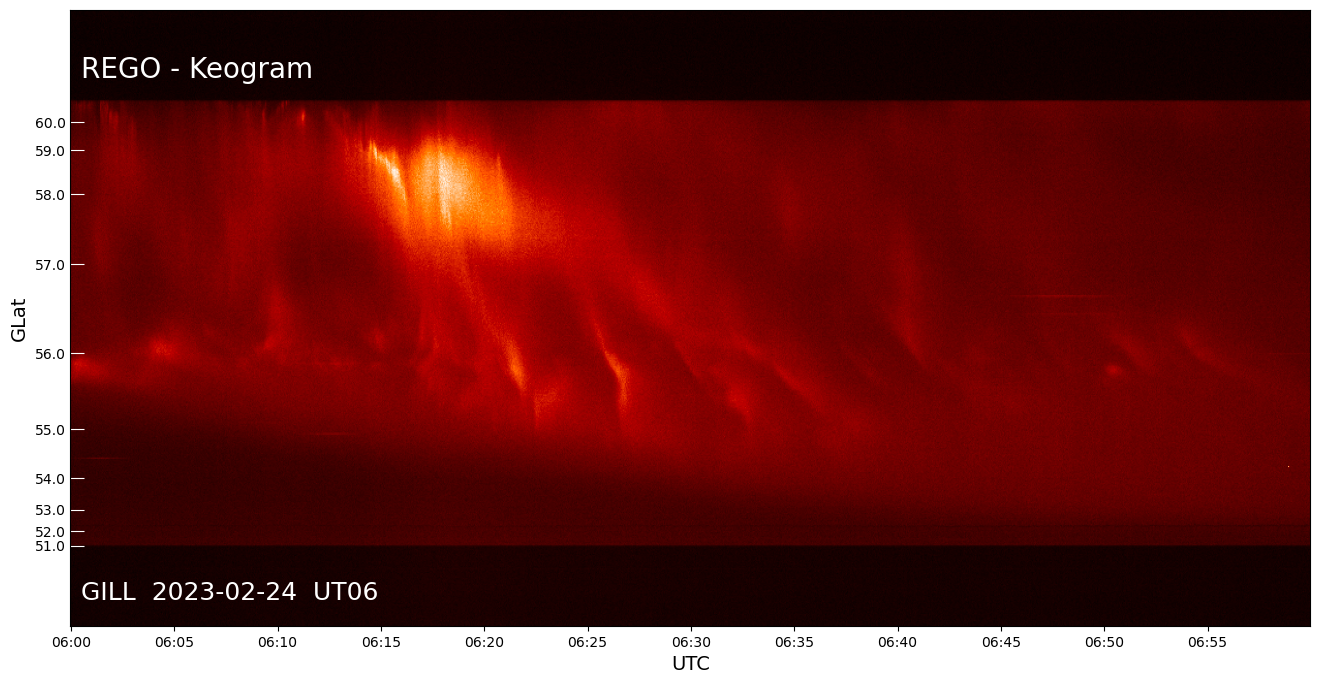

In [14]:
# Now that we have the latitude axis, create the keogram as usual
n_rows = img.shape[0]
n_imgs = img.shape[-1]
keogram = np.empty([n_rows, n_imgs])

# It will also be useful to create a list of the timestamps for each slice (from the metadata) to use as an axis.
time_string_list = list()

# Now, we can iterate through each image within the hour, and slice the middle column, whose
# index is determined by the width of a single image:
middle_column_idx = int( (img.shape[1])/2 - 1)
for img_idx in range(0,n_imgs):

    # For each iteration, we slice into 'img' to obtain a single image
    # frame, and then slice into that to obtain the center column:
    frame = img[:,:,img_idx]
    frame_middle_slice = frame[:,middle_column_idx]

    # Then, we simply insert each image slice into the corresponding location in the keogram
    keogram[:,img_idx] = frame_middle_slice

    # Lastly, we update the list of time strings with that from the current iteration's metadata
    iter_meta = meta[img_idx]
    timestamp = iter_meta["Image request start"]
    time_string = timestamp[11:16]
    time_string_list.append(time_string)

keogram = scale_image(keogram, cmin=250, cmax=1500)

# Plot the keogram
plt.figure(figsize=(16,8))
plt.imshow(keogram, cmap='gist_heat', aspect='auto')
plt.text(10, 56, 'REGO - Keogram', color='white', fontsize=20)
plt.text(10, 490, 'GILL  2023-02-24  UT06', color='white', fontsize=18)

# Generating the time axis
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.xlabel("UTC", fontsize=14)

# Now, for imshow() we need to manually remove any ticks we don't want to show up
# on the axis. We remove all except those closest to an integer latitude
nearest_int_idx = []
nearest_int_val = []
for j in range(51, 61):
  nearest_int_idx.append(np.where(np.nanmin(np.abs(lat_axis-j)) == np.abs(lat_axis-j))[0])
  nearest_int_val.append(str(lat_axis[np.where(np.nanmin(np.abs(lat_axis-j)) == np.abs(lat_axis-j))][0]))

str_lat_axis = np.round(lat_axis,1).astype(str)
str_lat_axis[:] = ''

for i in range(len(nearest_int_idx)):
  str_lat_axis[nearest_int_idx[i]] = str(round(float(nearest_int_val[i]),1))

plt.yticks(np.arange(0,len(str_lat_axis))[np.where(str_lat_axis != '')], str_lat_axis[np.where(str_lat_axis != '')])
plt.tick_params(axis='y', length=10, direction='in', color='white')
plt.ylabel("GLat", fontsize=14)
plt.show()

# Note: this plot also demonstrates the warping of the fish-eye lense

## **Geomagnetic Coordinates**

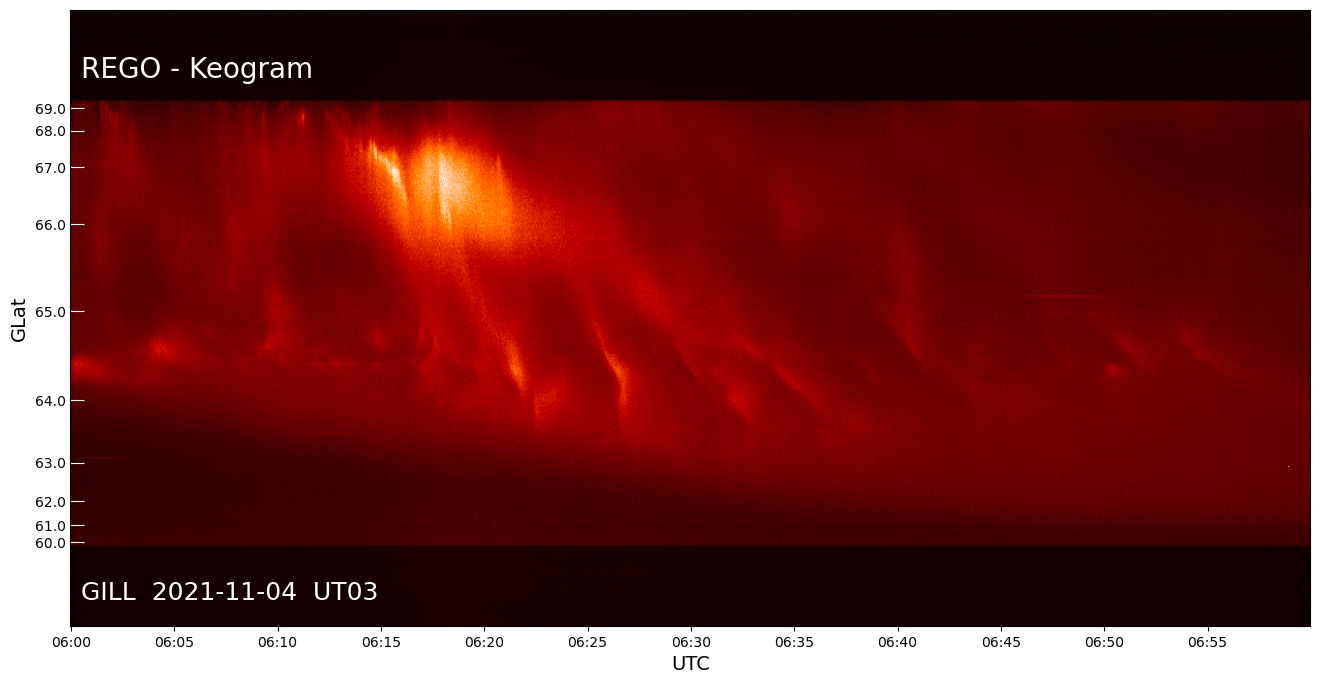

In [15]:
# Using the AACGM Python library, it is straightforward to convert the skymap coordinates
# for plotting in geomagnetic coordinates. In this case, we can easily convert our
# keogram axis

# AACGM conversion requires a datetime object
date_obj = dt.datetime(2023,2,24)

# We will also need the longitudes of the keogram column for the conversions
geo_lats = skymap['FULL_MAP_LONGITUDE'][2]
keo_column_idx = int( (img.shape[1])/2 - 1)

keo_lons = geo_lats[:,keo_column_idx].copy()

# Now, convert everything to magnetic coordinates
mag_lats, mag_lons, alt = aacgmv2.convert_latlon_arr(keo_lats, keo_lons, keo_lons*0.0, date_obj, method_code='G2A')

# Now, we can simply replot the keogram with our converted axis
plt.figure(figsize=(16,8))
plt.imshow(keogram, cmap='gist_heat', aspect='auto')
plt.text(10, 56, 'REGO - Keogram', color='white', fontsize=20)
plt.text(10, 490, 'GILL  2021-11-04  UT03', color='white', fontsize=18)

# Generating the time axis
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.xlabel("UTC", fontsize=14)

# Now, add the latitude axis we obtained previously
# lat_axis[np.isnan(lat_axis)] = 0
# Now, for imshow() we need to manually remove any ticks we don't want to show up
# on the axis. We remove all except those closest to an integer latitude
nearest_int_idx = []
nearest_int_val = []
for j in range(60, 70):
  nearest_int_idx.append(np.where(np.nanmin(np.abs(mag_lats-j)) == np.abs(mag_lats-j))[0])
  nearest_int_val.append(str(mag_lats[np.where(np.nanmin(np.abs(mag_lats-j)) == np.abs(mag_lats-j))][0]))

str_lat_axis = np.round(mag_lats,1).astype(str)
str_lat_axis[:] = ''

for i in range(len(nearest_int_idx)):
  str_lat_axis[nearest_int_idx[i]] = str(round(float(nearest_int_val[i]),1))

plt.yticks(np.arange(0,len(str_lat_axis))[np.where(str_lat_axis != '')], str_lat_axis[np.where(str_lat_axis != '')])
plt.tick_params(axis='y', length=10, direction='in', color='white')
plt.ylabel("GLat", fontsize=14)
plt.show()

## **Creating a Mosaic**



---


The process of making a mosaic involves properly accounting for the mapping of each pixel. Due to the fisheye optics, the pixels become increasingly large as you move away from zenith, to lower elevation angles.

  Our methodology for creating mosaics relies on two key points.


1.   we must accurately account for the changing (and unique) pixel areas and locations in geodetic coordinates, and
2.   when putting multiple imagers together, we want to use the information from the closest camera

Our methodology involves creating exact polygons for each pixel (this is why the skymap contains the pixel corners!), for each camera and filling those polygons with the correct (scaled, or calibrated) imager data. This methodology ensures accuracy of all pixels within the FoV.

The procedure for making a mosaic is best done in 1D vector space.  Below you will find functions that convert the skymaps and images to vectors, before plotting those vectors. **Please do not worry about understanding these functions, you may just use them.**


---



In [16]:
# FUNCTION: flatten_skymaps
#
# This function will take a list of skymap files, and flatten the into a new format
# of skymaps that can be used in plotting multiple images on a map, masking the
# boundaries between images by elevation angle
#
# Inputs:
#
# skymap_filename_list - List filenames from which to obtain each site's skymap
# site_id_list - List of site_id strings, in order corresponding to skymap file list, e.g. ['atha', 'gill']
# height_km - The height at which the image data is to be mapped onto the map from (assumed altitude of data)
#
# (Optional) imager_id - String corresponding to the imager dataset for which skymaps correspond to, e.g. 'REGO'
# (Optional) image_dimensions - list containing the size of a single image [height, width]
#            Note, either image_dimensions or imager_id must be passed
def flatten_skymaps(skymap_filename_list, site_id_list, height_km, imager_id=None,  image_dimensions=None):

    # Define the dimensions for the images we are working with
    if image_dimensions == None:
      if imager_id == None:
        raise Exception("Please use either imager_id or image_dimensions keywords to define data size.")
      if imager_id == 'themis' or imager_id == 'nir':
        height, width = (256, 256)
      elif imager_id == 'rego' or imager_id == 'nascam':
        height, width = (512, 512)
      elif imager_id == 'blue':
        height, width = (320, 270)
      elif imager_id == 'rgb':
        height, width = (480, 553)

    else:
      width = image_dimensions[1]
      height = image_dimensions[0]

    n_sites = len(skymap_filename_list)

    # Define empty numpy arrays for the lats, lons, and elevation
    # angles of all of the sites. Also define numpy arrays for
    # 'filling' the pixel coordinates, which will contain polygons
    # vertices in lat/lon.
    lats = np.zeros((n_sites, 3, height+1, width+1))
    lons = np.zeros((n_sites, 3, height+1, width+1))
    elevation = np.zeros((n_sites, width*height))
    polyfill_lat = np.zeros((n_sites, width*height, 4))
    polyfill_lon = np.zeros((n_sites, width*height, 4))
    site_lonlat = np.zeros((n_sites, 2))

    # Do one site at a time
    for i in tqdm(range(0,n_sites), desc="Flattening Skymaps"):

        # Restore the skymap into a Python dict
        skymap_path = skymap_filename_list[i]
        skymap = restore_skymap(skymap_path)

        # Grab the necessary data from the skymap
        altitudes = skymap["FULL_MAP_ALTITUDE"]
        lats[i,:,:,:] = skymap["FULL_MAP_LATITUDE"]
        tmp_lons = np.array(skymap["FULL_MAP_LONGITUDE"])
        tmp_lons[np.where(tmp_lons > 180)] -= 360
        lons[i,:,:,:] = tmp_lons
        site_lonlat[i,0] = skymap["SITE_MAP_LONGITUDE"]
        site_lonlat[i,1] = skymap["SITE_MAP_LATITUDE"]
        elev = skymap["FULL_ELEVATION"]

        # Iterate through each image pixel
        for ii in range(0,height-1):
            for jj in range(0, width-1):

                # Grab the longitudes of the corners of this pixel, at all three
                # assumed altitudes included in the skymap, and then use interpolation
                # to obtain the pixel corner coordinates at the input height. Then
                # add this array of coordinates (polygon) to the filling array.
                lon1 = np.interp(height_km, altitudes, lons[i,:,ii,jj])
                lon2 = np.interp(height_km, altitudes, lons[i,:,ii,jj+1])
                lon3 = np.interp(height_km, altitudes, lons[i,:,ii+1,jj+1])
                lon4 = np.interp(height_km, altitudes, lons[i,:,ii+1,jj])
                polyfill_lon[i, jj*height+ii,:] = np.array([lon1, lon2, lon3, lon4])

                # Repeat the above for latitudes.
                lat1 = np.interp(height_km, altitudes, lats[i,:,ii,jj])
                lat2 = np.interp(height_km, altitudes, lats[i,:,ii,jj+1])
                lat3 = np.interp(height_km, altitudes, lats[i,:,ii+1,jj+1])
                lat4 = np.interp(height_km, altitudes, lats[i,:,ii+1,jj])
                polyfill_lat[i, jj*height+ii,:] = np.array([lat1, lat2, lat3, lat4])

                # Add the current pixel's elevation angle to it's corresponding
                # place in the elevation array.
                elevation[i, jj*height+ii] = elev[ii,jj]

    # Once all site's indices have been filled in, return the flattened skymap as a dict.
    flattened_skymap = {'site_id':site_id_list,
                        'lons':lons,
                        'lats':lats,
                        'elevation':elevation,
                        'polyfill_lon':polyfill_lon,
                        'polyfill_lat':polyfill_lat,
                        'site_lonlat':site_lonlat}
    return(flattened_skymap)

In [17]:
# FUNCTION: load_image_data_single_channel
#
# This function will take a list of image files, and convert them into a format
# that is compatible with the flattened skymaps for plotting.
#
# Inputs:
#
# image_filename_list - List of image files from which to read the data
# imager_id - String giving the imager dataset to which the files correspond, e.g. 'rego'
def load_image_data_single_channel(image_filename_list, imager_id):

    imager_id = imager_id.lower()
    n_sites = len(image_filename_list)

    # Obtain the dimensions of the images we are working with, as
    # well as the imaging cadence (s/frame). From this compute the
    # number of images that are expected for one minute of dataa.
    if imager_id == 'themis':
        height, width = (256, 256)
        cadence = 3
    if imager_id == 'rego':
        height, width = (512, 512)
        cadence = 3
    if imager_id == 'nir':
        height, width = (256, 256)
        cadence = 6
    if imager_id == 'blue':
      height, width = (320, 270)
      cadence = 3
    if imager_id == 'nascam':
      height, width = (512, 512)
      cadence = 6

    predicted_n_imgs = int(60 / cadence)

    # Define an empty dictionary to hold all of the data, and
    # then go through one site eat a time.
    data = {}
    for i in range(0,n_sites):

        # For each site, create an empty dictionary to hold the image data
        # as well as the timestmap data, formatted as arrays, whose shapes
        # correspond to the expected (max) number of frames for one minute.
        site_data = {'images':np.empty((height,width,predicted_n_imgs)),
                     'time_stamp':np.empty((predicted_n_imgs), dtype=object)}

        # Read in this site's data
        if imager_id == 'themis':
            img, meta, problematic_files = themis_imager_readfile.read(image_filename_list[i])
        if imager_id == 'rego':
            flipped_img, meta, problematic_files = rego_imager_readfile.read(image_filename_list[i])
            img = np.flip(flipped_img, axis=1)
        if imager_id == 'nir':
            img, meta, problematic_files = trex_imager_readfile.read_nir(image_filename_list[i])
        if imager_id == 'blue':
            img, meta, problematic_files = trex_imager_readfile.read_blue(image_filename_list[i])
        if imager_id == 'nascam':
            img, meta, problematic_files = nascam_imager_readfile.read(image_filename_list[i])

        # Detemined how many frames are actually included in this image array
        if img.shape[-1] <= predicted_n_imgs:
            real_n_imgs = img.shape[-1]
        else:
            real_n_imgs = 1

        # Obtain the site_id to use as dictionary key, and grab date
        site_id = meta[0]['Site unique ID']
        meta_datestamp = meta[0]['Image request start'][0:10]

        # Generate a list of time strings that correspond to the predicted
        # image frames for this instrument.
        predicted_ts_list = np.empty((predicted_n_imgs), dtype=object)
        for ii in range(0,predicted_n_imgs):
            expected_timestamp = meta[0]["Image request start"][11:17]+f'{cadence*ii:02d}'
            predicted_ts_list[ii] = expected_timestamp

        # Iterate through each frame in the real image array, and obtain the
        # timestamp from the metadata.
        for j in range(0,real_n_imgs):

            # Obtain the index of the predicted timestamp array that this real
            # timestamp is a match with. This is done to avoid discrepancys when
            # an imager skips a frame, or say, begins imaging partway through a minute.
            real_ts = meta[j]["Image request start"][11:19]
            ts_idx = np.where(predicted_ts_list == real_ts)

            if len(ts_idx) != 1:
                print("Predicted timestamps: ", predicted_ts_list)
                print("Actual timestamp: ", real_ts)
                raise Exception("Error in timestamp comparison. See above for info.")

            # Add the image data, and timestmap, to the their actual location in the full
            # arrays, according to where the predicted timestamps say it belongs
            site_data['images'][:,:,ts_idx[0][0]] = img[:,:,j]
            site_data['time_stamp'][ts_idx[0][0]] = real_ts
            site_data['date_stamp'] = meta_datestamp

        # Once all frames have been loaded, add this site's data to the master dictionary
        data[site_id] = site_data

    return(data)

In [18]:
# FUNCTION: plot_mosaic_single_channel
#
# This function will take the flattened skymap and image data, and return a plot object
# of a mosaic.
#
# Input:
#
# map_extent - List of geographic lat, lon bounds of the map, in format [minlon, maxlon, minlat, maxlat]
# desired_projection - A cartopy.crs object, specifying the desired map projection to plot in
# image_data - Dictionary containing the image data to be plotted, usually the return value of load_image_data_single_channel()
# site_list - List of site_id names to be plotted, e.g. ['luck', 'gill', 'atha']
# flattened_skymap - The flattened skymap object obtained from the flatten_skymaps() function
#
# (Optional) scaling_bounds - The scaling floor and ceiling to be applied to the image data.
#                             Dictionary for site independent scaling, e.g. {'atha':[100,5000], 'fsmi':[150,2500]}
#                             List for scaling all sites the same, e.g. [300, 2500]
# (Optional) imager_id - String corresponding to the imager dataset for which skymaps correspond to, e.g. 'rego'
# (Optional) image_dimensions - list containing the size of a single image [height, width]
#            Note, either image_dimensions or imager_id must be passed
# (Optional) elevation_threshold - The elevation masking to be applied, defaults to 5 degrees
# (Optional) frame_idx - The frame idx to plot if the image data contains multiple frames
# (Optional) rayleighs - Indicates that the data units are in Rayleighs, default is False, indicating data number units
# (Optional) colormap - A matplotlib.cm colormap object to be used for plotting
def plot_mosaic_single_channel(map_extent, desired_projection, image_data, site_list, flattened_skymap, scaling_bounds=None, imager_id=None, image_dimensions=None, elevation_threshold=5, frame_idx=0, rayleighs=False, colormap=None):

  # Initialize the plotting figure/axis
  mosaic = plt.figure(figsize=(10,10))
  ax = plt.axes(projection=desired_projection)
  ax.set_extent(map_extent, crs=cartopy.crs.Geodetic())
  ax.add_feature(cartopy.feature.OCEAN, zorder=0)
  ax.add_feature(cartopy.feature.LAND, facecolor='gray', edgecolor='black', zorder=0)

  # Now, in order to convert from geodetic coordinates onto the map projection, we will
  # use PyProj, as it is much more efficient in doing so than Cartopy. We can define
  # a transformation object between geodetic coordinates and our desired projection:
  pyproj_src_proj = pyproj.CRS.from_user_input(cartopy.crs.Geodetic())
  pyproj_des_proj = pyproj.CRS.from_user_input(desired_projection)
  transformer = pyproj.Transformer.from_crs(pyproj_src_proj, pyproj_des_proj, always_xy=True)

  # Define the dimensions of the data
  if imager_id != None:
    imager_id = imager_id.lower()

  if image_dimensions == None:
    if imager_id == None:
      raise Exception("Enter image_dimensions or imager_id")

    if imager_id == 'themis':
      height, width = (256, 256)
      n_imgs = 20
    elif imager_id == 'rego':
      height, width = (512, 512)
      n_imgs = 20
    if imager_id == 'blue':
      height, width = (320, 270)
      n_imgs = 20
    if imager_id == 'nascam':
      height, width = (512, 512)
      n_imgs = 10
    if imager_id == 'nir':
      height, width = (256, 256)
      n_imgs = 10
  else:
    width = image_dimensions[1]
    height = image_dimensions[0]
    n_imgs = image_dimensions[2]

    if width < n_imgs or height < n_imgs:
      raise Exception("Enter Dimensions in format: [height, width, n_imgs]")

  n_sites = len(site_list)

  # If scaling bounds are not passed manually, defaults to scaling all sites beteen 0-20000
  if scaling_bounds == None:
    if rayleighs:
      max_rayleighs = 20000
    scaling_bounds = {}
    for site_to_scale in flattened_skymap['site_id']:
      scaling_bounds[site_to_scale] = [0, 20000]

  # If scaling bounds are passed as a single list, set scaling to those bounds for all images
  if isinstance(scaling_bounds, list) and len(scaling_bounds) == 2:
    if rayleighs:
      max_rayleighs = scaling_bounds[1]
    tmp_bounds = scaling_bounds
    scaling_bounds = {}
    for site_to_scale in flattened_skymap['site_id']:
      scaling_bounds[site_to_scale] = [tmp_bounds[0], tmp_bounds[1]]

  # We need a numpy array of the sites requested, that will be used to make sure any sites
  # that don't have data for the requested frame are not plotted. Then we will define three
  # numpy arrays: img_tmp will hold the image data of each site, sorted according to elevation
  # angle, which is done using the other two arrays, elev and s.
  site_list_arr = np.array(site_list)
  img_tmp = np.zeros((n_sites, width*height), dtype=np.int32)
  elev = np.zeros((n_sites, width*height))
  s = np.zeros((n_sites, width*height), dtype=np.int32)

  # Now we begin to fill in the above arrays, one site at a time. Before doing so
  # we need lists to keep track of which sites actually have data for this frame.
  sites_with_data = []
  sites_with_data_idx = []

  # We also define a list that will hold all unique timetamps pulled from each
  # frame's metadata. This should be of length 1, and we can check that to make
  # sure all images being plotted correspond to the same time.
  unique_timestamps = []
  for site_idx, site in enumerate(site_list):

      meta_timestamp = image_data[site]["time_stamp"][frame_idx]
      meta_datestamp = image_data[site]["date_stamp"]

      # Set this sorting array at this site's index equal to the indices
      # that would sort the flattened elevation skymap. Then use this to
      # insert the sorted elevations into the elev array for this site.
      s[site_idx,:] = np.argsort(flattened_skymap["elevation"][site_idx,:])
      elev[site_idx, :] = flattened_skymap["elevation"][site_idx, s[site_idx,:]]

      # Now, obtain the frame of interest, for this site, from the image data. If
      # it's sum is zero, we know there is no data so we can simply continue.
      tmp1 = image_data[site]["images"][:,:,frame_idx]
      if np.sum(tmp1) == 0.0:
          continue

      # If there is data, first update our list for tracking which sites have data
      # as well as their indices.
      else:

          # Scale this site's data based on previously defined scaling bounds
          tmp1 = scale_image(tmp1, cmin = scaling_bounds[site][0], cmax = scaling_bounds[site][1], high=255)

          # Add the timestamp to tracking list if it's unique
          if meta_timestamp not in unique_timestamps:
              unique_timestamps.append(meta_timestamp)

          sites_with_data.append(site)
          sites_with_data_idx.append(np.where(site_list_arr == site)[0][0])

          # Iterate through all the pixels in order of elevation and add them to the reformed data array
          for ii in range(0,height):
              for jj in range(0,width):
                  # Update the master flattened image, for this site, with the bytescaled pixel value,
                  # scaled based on the max and min we defined for this site.
                  img_tmp[site_idx, jj*height+ii]=tmp1[ii,jj]

  # This checks to make sure all images have the same timestamps
  if len(unique_timestamps) != 1:
      raise Exception("Error: Images have different timestamps.")

  # Now that all of the image data has been sorted and stored properly
  # we will iterate through and obtain all of the coordinate polygons
  # that correspond to each pixel. We need two lists, to keep track of
  # the coordinate vertices, as well as the value of each pixel.
  lon_list = []
  lat_list = []
  cmap_vals = []
  for ii in range(0,width*height):

      # Only iterate through the sites that actually have data
      for site, site_idx in zip(sites_with_data, sites_with_data_idx):

          lons = flattened_skymap["polyfill_lon"][site_idx,s[site_idx,ii],:]
          lats = flattened_skymap["polyfill_lat"][site_idx,s[site_idx,ii],:]

          # Only proceed if this pixel has 4 non-NaN corner coordinates, and is
          # above the elevation threshold we are interested in plotting
          if elev[site_idx,ii] < elevation_threshold:
              continue
          if len(lons[~ np.isnan(lons)]) != 4:
              continue
          if len(lats[~ np.isnan(lats)]) != 4:
              continue

          # Append lats and lons of vertices to lists
          lon_list.append(lons)
          lat_list.append(lats)

          # Convert this pixel's value to a float (0.-1.) and append to master list
          pixel_value = float(img_tmp[site_idx,s[site_idx,ii]]) / 255.
          cmap_vals.append(pixel_value)

  # Use our transformer object to convert the lat/lon polygons into projection coordinates.
  lons, lats = transformer.transform(np.array(lon_list), np.array(lat_list))
  lonlat_polygons = np.empty((lons.shape[0],4,2))
  lonlat_polygons[:,:,0] = lons
  lonlat_polygons[:,:,1] = lats

  if colormap == None:
    if imager_id != None:
      if imager_id == 'rego' or imager_id == 'nir':
        plotting_colormap = matplotlib.cm.gist_heat
      elif imager_id == 'blue':
        plotting_colormap = matplotlib.cm.bone
      else:
        plotting_colormap = matplotlib.cm.gray
  else:
    plotting_colormap = colormap

  # Generate a PolyCollection object, containing all of the Polygons shaded with their corresponding RGB value
  img_data_poly = matplotlib.collections.PolyCollection(lonlat_polygons, array=cmap_vals, cmap=plotting_colormap, clim=[0.0,1.0], edgecolors='face')

  # Finally, we can add the PolyCollection object to our plotting axis, and display
  ax.add_collection(img_data_poly)

  if rayleighs:
    # Create a colorbar, in Rayleighs, that accounts for the scaling limit we applied
    cbar_ticks = [float(j)/5. for j in range(0,6)]
    cbar_ticknames = [str(int(max_rayleighs/5)*j) for j in range(0,6)]

    # Any pixels with the max Rayleigh value could be greater than it, so we include the plus sign
    cbar_ticknames[-1] += '+'
    cbar = plt.colorbar(img_data_poly, shrink=0.5, ticks = cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticknames)
    plt.text(1.025, 0.5, "Intensity (Rayleighs)", fontsize=14, transform=ax.transAxes, va='center', rotation='vertical', weight='bold', style='oblique')

  return(mosaic)

Flattening Skymaps:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\darrenc\anaconda3\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\darrenc\anaconda3\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


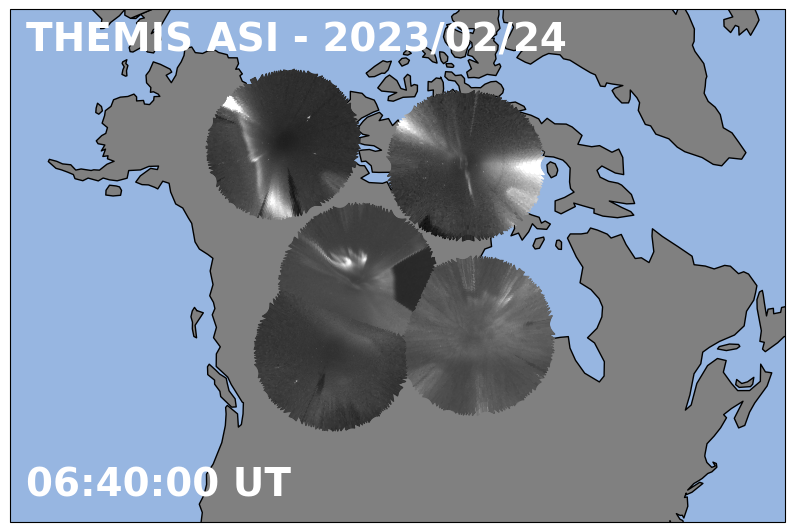

In [19]:
#  BUILD A MOSAIC

# Now we can begin actually making the mosaic, using the previously defined functions.

# Pick a couple sites that have clear data for the time of interest
imager_id = 'themis'
site_list = sorted(['fsmi', 'gill', 'inuv', 'atha', 'talo'])

# Pick the altitude that the interpolation will map the data at
height_km = 110

# Let's load in image data corresponding to the site_list, for our time of interest
image_file_list = sorted(glob.glob(os.path.join(download_root_path, 'THEMIS_ASI_STREAM0_RAW', '2023', '02', '24', '*', 'ut06', '20230224_0640_*_full.pgm.gz')))

# Now, we need skymaps corresponding to each site that we are loading image data for. Let's
# load in the skymap files that were created most recently prior to the date of interest.
skymap_file_list = sorted(glob.glob(os.path.join(download_root_path, 'skymap', 'themis', '*', '*', '*.sav')))

# Next, let's use our previously defined functions to flatten the skymaps
# as well as the image data, so it is in a format to be plotted properly.
image_data = load_image_data_single_channel(image_file_list, imager_id)
flattened_skymap = flatten_skymaps(skymap_file_list, site_list, height_km, imager_id=imager_id)

# Let's define the scaling bounds for the images. For this example, upon
# inspecting the data, one will see that some sites, namely INUV, ATHA, and
# TALO, are a bit darker, so let's scale those ones up more
scale = {'fsmi':[2000, 10000],
         'inuv':[2000, 5500],
         'atha':[2000, 6000],
         'gill':[2000, 10000],
         'talo':[2000, 6000]}

# We will use Cartopy to initialize the actual map projection and boundaries. See Cartopy's
# docs for info about other projections, we will use a satellite view here.
projection = cartopy.crs.NearsidePerspective(central_longitude=-100, central_latitude=55, satellite_height=35785831)
min_elevation = 5
map_extent = [-145, -65, 35, 80]

# Call the plotting function, and add some labels to the map
mosaic = plot_mosaic_single_channel(map_extent, projection, image_data, site_list, flattened_skymap, scaling_bounds=scale, imager_id=imager_id, elevation_threshold=min_elevation)
print()
plt.text(0.02, 0.92,'THEMIS ASI - 2023/02/24', color='white', fontsize=28, weight='bold', transform = mosaic.gca().transAxes)
plt.text(0.02, 0.05,'06:40:00 UT', color='white', fontsize=28, weight='bold', transform = mosaic.gca().transAxes)
plt.show()

## **Mosaic of Luminosity in Rayleighs**

Using methods outlined in the 'loading calibrating and plotting single channel ASI data, we can  
convert image data to physical units (Rayleighs) and create a mosaic with more physical meaning.  


In [20]:
# Let's load in some REGO data - we will also need the calibration files, as explained in
# the 'loading, calibrating, and plotting single channel asi data' crib sheet.

imager_id = 'rego'
height_km = 230
site_list = ['fsim', 'gill', 'luck', 'rank']

# Grabbing image data for sites with good data
image_file_list = [os.path.join(download_root_path, 'REGO_STREAM0_RAW', '2023', '02', '24', 'fsim_rego-656', 'ut06', '20230224_0615_fsim_rego-656_6300.pgm.gz'),
                   os.path.join(download_root_path, 'REGO_STREAM0_RAW', '2023', '02', '24', 'gill_rego-652', 'ut06', '20230224_0615_gill_rego-652_6300.pgm.gz'),
                   os.path.join(download_root_path, 'REGO_STREAM0_RAW', '2023', '02', '24', 'luck_rego-651', 'ut06', '20230224_0615_luck_rego-651_6300.pgm.gz'),
                   os.path.join(download_root_path, 'REGO_STREAM0_RAW', '2023', '02', '24', 'rank_rego-649', 'ut06', '20230224_0615_rank_rego-649_6300.pgm.gz')]

# Getting correspinding skymaps
skymap_file_list = [os.path.join(download_root_path, 'skymap', 'rego', 'fsim', 'fsim_20220902', 'rego_skymap_fsim_20220902-+_v01.sav'),
                    os.path.join(download_root_path, 'skymap', 'rego', 'gill', 'gill_20230124', 'rego_skymap_gill_20230124-+_v01.sav'),
                    os.path.join(download_root_path, 'skymap', 'rego', 'luck', 'luck_20220902', 'rego_skymap_luck_20220902-+_v01.sav'),
                    os.path.join(download_root_path, 'skymap', 'rego', 'rank', 'rank_20221214', 'rego_skymap_rank_20221214-+_v01.sav')]

# Now we need the flatfield calibration files - make sure to match the correct imager ids (explained in calibration crib sheet)
flatfield_file_list = [os.path.join(download_root_path, 'calibration', 'REGO_flatfield_15656_20220613-+_v02.sav'),
                       os.path.join(download_root_path, 'calibration', 'REGO_flatfield_15652_20141102-+_v01.sav'),
                       os.path.join(download_root_path, 'calibration', 'REGO_flatfield_15651_20210908-+_v02.sav'),
                       os.path.join(download_root_path, 'calibration', 'REGO_flatfield_15649_20211019-+_v02.sav')]

# Get the rayleigh calibration files as well
rayleighs_file_list = [os.path.join(download_root_path, 'calibration', 'REGO_Rayleighs_15656_20220613-+_v02.sav'),
                       os.path.join(download_root_path, 'calibration', 'REGO_Rayleighs_15652_20141102-+_v01.sav'),
                       os.path.join(download_root_path, 'calibration', 'REGO_Rayleighs_15651_20210908-+_v02.sav'),
                       os.path.join(download_root_path, 'calibration', 'REGO_Rayleighs_15649_20211019-+_v02.sav')]

In [21]:
# Now, using  previously defined functions to flatten the skymaps as well
# as the image data, so it is in a format to be plotted properly.
image_data = load_image_data_single_channel(image_file_list, imager_id)
flattened_skymap = flatten_skymaps(skymap_file_list, site_list, height_km, imager_id=imager_id)

Flattening Skymaps:   0%|          | 0/4 [00:00<?, ?it/s]

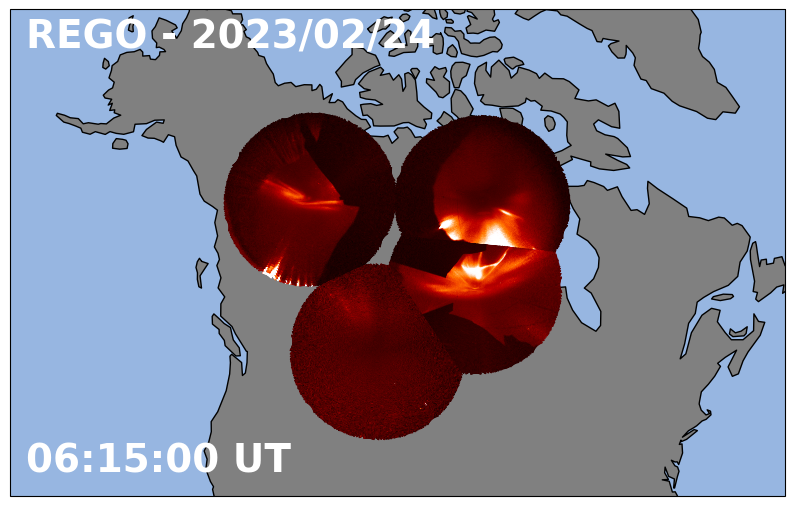

In [22]:
# Let's define the scaling bounds for the images.
scale = {'fsim':[250, 1000],
         'gill':[250, 1000],
         'luck':[250, 500],
         'rank':[250, 1000]}

# Define some parameters about the mosaic
projection = cartopy.crs.NearsidePerspective(central_longitude=-100, central_latitude=55, satellite_height=35785831)
min_elevation = 5
map_extent = [-145, -65, 33, 75]

mosaic = plot_mosaic_single_channel(map_extent, projection, image_data, site_list, flattened_skymap, imager_id=imager_id, scaling_bounds=scale, elevation_threshold=min_elevation)
plt.text(0.02, 0.92,'REGO - 2023/02/24', color='white', fontsize=28, weight='bold', transform = mosaic.gca().transAxes)
plt.text(0.02, 0.05,'06:15:00 UT', color='white', fontsize=28, weight='bold', transform = mosaic.gca().transAxes)
plt.show()

**The above mosaic is for the raw (uncalibrated) REGO data, mapped to 230km. From the previous crib sheet, we can also apply the radiometric calibration to the REGO and make a mosaic in units of calibrated luminosity (Rayleighs)**

Note: when we compute our flat field correction, we limit the FoV to 10 degree elevation angle, so calibrated mosaics will require a 10 degree elevation threshold.

In [23]:
# Now, let's calibrate the image data, using the methods explained in the
# load_cal_plot_single_channel_asi_data crib sheet

calibrated_data = image_data
for i, site in enumerate(site_list):

  # Obtain calibration info for this site
  flatfield_f_path = flatfield_file_list[i]
  rayleighs_f_path = rayleighs_file_list[i]
  device_id = flatfield_f_path.split('flatfield_')[-1][2:5]

  flatfield_arr = scipy.io.readsav(flatfield_f_path)["flat_field_multiplier_15"+device_id]
  rayleighs_per_dns = scipy.io.readsav(rayleighs_f_path)["rper_dnpersecond_15"+device_id]

  # Iterate through each image in the raw data so that the full minute is calibrated
  raw_img = image_data[site]['images']
  n_imgs = raw_img.shape[-1]

  for j in range(0,n_imgs):

    img_j = raw_img[:,:,j]

    # 1. Compute the dark frame for this image and subtract it
    bottom_row_idx = int((img_j.shape[0]) - 1)
    dark_array = img_j[bottom_row_idx-4:, 0:5]
    dark_counts = np.mean(dark_array)
    original_dtype=img_j.dtype
    signed_single_img = img_j.astype(np.int32)

    dark_corrected_img = signed_single_img - int(dark_counts)
    dark_corrected_img[np.where(dark_corrected_img < 0)] = 0
    dark_corrected_img = dark_corrected_img.astype(original_dtype)

    # 2. Perform flat field correction
    flatfield_calibrated_img = dark_corrected_img * flatfield_arr

    # 3. Convert to Rayleighs
    exposure_millisecs = float(meta[j]['Exposure plus readout'].split(' ')[0])
    exposure_secs = exposure_millisecs / 1000.

    calibrated_img_j = flatfield_calibrated_img * rayleighs_per_dns * exposure_secs

    calibrated_data[site]['images'][:,:,j] = calibrated_img_j

C:\Users\darrenc\anaconda3\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\darrenc\anaconda3\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


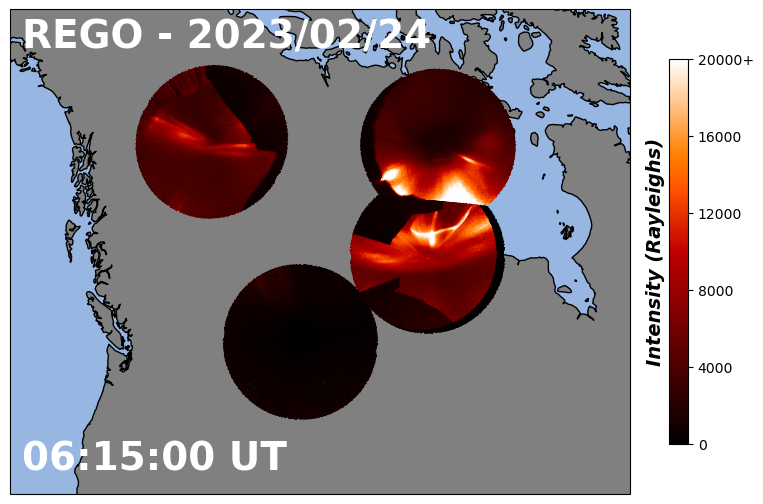

In [24]:
# Now that the image data object is calibrated we can make another call
# To our mosaic plotting function.

# Note that now scale is in units of Rayleighs. We also set the elevation mask
# at 10 degrees, as that is the boundary for which these calibration files were generated.
min_elevation = 10
scale = [0, 20000]
map_extent = [-130, -80, 40, 69]
projection = cartopy.crs.NearsidePerspective(central_longitude=-100, central_latitude=55, satellite_height=35785831)

# The rayleighs=True keyword adds a colorbar visualization with units
mosaic = plot_mosaic_single_channel(map_extent, projection, calibrated_data, site_list, flattened_skymap, imager_id=imager_id, scaling_bounds=scale, elevation_threshold=min_elevation, rayleighs=True)
plt.text(0.02, 0.92,'REGO - 2023/02/24', color='white', fontsize=28, weight='bold', transform = mosaic.gca().transAxes)
plt.text(0.02, 0.05,'06:15:00 UT', color='white', fontsize=28, weight='bold', transform = mosaic.gca().transAxes)
plt.show()